In [1]:
# Smarter Circuits #
import sys
sys.path.append('../')


import imagePreprocessing as ip
import graphGeneration as gg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import lib.utils as utils
import os
import random
import string

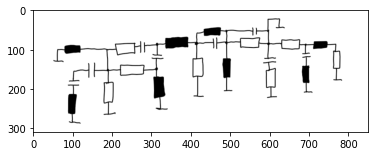

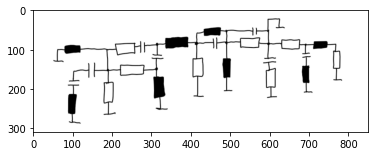

In [2]:
name = "raf_1.png"

image = utils.loadImage(path="./../resources/testImages",name=name, resize=(850,None))

colorImage = utils.loadImage(path="./../resources/testImages",name=name, resize=(850,None), color=True)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

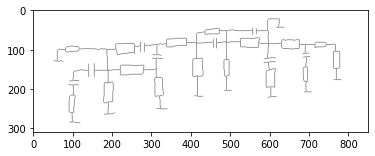

In [3]:
preprocessedImage = ip.preprocessImage(image)
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [4]:
#class_names = os.listdir('./../trainData')
#
#for class_name in class_names:
#    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))

def generateTrainData(boundingBoxes, image):
    counter = []
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        utils.saveImage(path='./../resources/trainData/')
        #utils.saveImage(name="{i}.png".format(i=''.join(random.choice(string.ascii_lowercase) for i in range(10))), image=component)

end reached
30


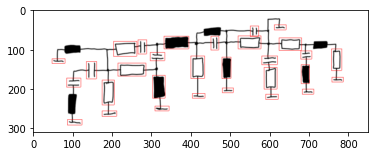

In [5]:
boundingBoxes = gg.generateBoudingBoxes(preprocessedImage)

#generateTrainData(boundingBoxes, image)
print(len(boundingBoxes))

def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0))
#colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")

In [6]:
predictions = cc.classify(boundingBoxes, image)

print(len(predictions))

30


inductor -> blue
resistor -> green
capacitor -> red
ground -> purple


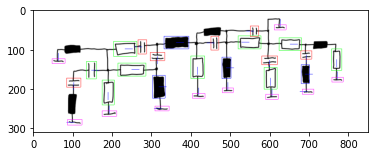

In [7]:
for i in range(0, len(boundingBoxes)):
    colorImage = utils.drawArrow(colorImage,boundingBoxes[i],predictions[i][1],[255,0,0])
    if predictions[i][0] == "inductor":
        colorImage = utils.drawRect(colorImage,boundingBoxes[i],[255,0,0])
    elif predictions[i][0] == "resistor":
        colorImage = utils.drawRect(colorImage,boundingBoxes[i],[0,255,0])
    elif predictions[i][0] == "capacitor":
        colorImage = utils.drawRect(colorImage,boundingBoxes[i],[0,0,255])
    elif predictions[i][0] == "ground":
        colorImage = utils.drawRect(colorImage,boundingBoxes[i],[255,0,255])
    
print("inductor -> blue")
print("resistor -> green")
print("capacitor -> red")
print("ground -> purple")


utils.saveImage(name="boundingBoxes.png", image=colorImage, color=True)
colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage)